# Modeling a 1D Scalar

This notebook visualizes the training and generation of a Bayesian flow network [(Graves et al. 2023)](https://arxiv.org/pdf/2308.07037.pdf) modeling a 1D scalar.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

In [11]:
from bfn.config import TrainingConfig, SamplingConfig
from bfn.networks import Network
from bfn.training import train
from bfn.generation import generate

## Plotting code

In [12]:
def visualize_training(losses, ts, gammas, mus, alphas, x, subsample_every=1):
  """
    Let B = batch size and T = number of training steps

    losses: (T,)
    ts: (B*T,)
    gammas: (B*T,)
    mus: (B*T,)
    alphas: (B*T,)
  """
  # subsampling
  subsampled_losses = losses[::subsample_every]
  subsampled_ts = ts[::subsample_every]
  subsampled_gammas = gammas[::subsample_every]
  subsampled_mus = mus[::subsample_every]
  subsampled_alphas = alphas[::subsample_every]
  indices = range(len(subsampled_ts))

  # plotting parameters
  cmap = 'inferno'
  scatter_size = 0.5

  # Create a 5x2 grid of subplots
  fig, axes = plt.subplots(2, 5, figsize=(24, 8))

  # Plot 0: Scatter plot of ts
  sc0 = axes[0, 0].scatter(indices, subsampled_ts, s=scatter_size, c=indices, cmap=cmap)
  axes[0, 0].set_title("$t$ with respect to training steps")

  # Plot 1: Scatter plot of ts with respect to ts
  axes[1, 0].scatter(subsampled_ts, subsampled_ts, s=scatter_size, c=indices, cmap=cmap)
  axes[1, 0].set_title("$t$ with respect to $t$")

  # Plot 2: Scatter plot of gammas
  axes[0, 1].scatter(indices, subsampled_gammas, s=scatter_size, c=indices, cmap=cmap)
  axes[0, 1].set_title("$\\gamma$ with respect to training steps")

  # Plot 3: Scatter plot of gammas with respect to ts
  axes[1, 1].scatter(subsampled_ts, subsampled_gammas, s=scatter_size, c=indices, cmap=cmap)
  axes[1, 1].set_title("$\\gamma$ with respect to $t$")

  # Plot 4: Scatter plot of alphas
  axes[0, 2].scatter(indices, subsampled_alphas, s=scatter_size, c=indices, cmap=cmap)
  axes[0, 2].set_title("$\\alpha$ with respect to training steps")

  # Plot 5: Scatter plot of alphas with respect to ts
  axes[1, 2].scatter(subsampled_ts, subsampled_alphas, s=scatter_size, c=indices, cmap=cmap)
  axes[1, 2].set_title("$\\alpha$ with respect to $t$")

  # Plot 6: Scatter plot of mus
  axes[0, 3].scatter(indices, subsampled_mus, s=scatter_size, c=indices, cmap=cmap)
  axes[0, 3].axhline(y=x, color='slategray', linestyle='-')
  axes[0, 3].text(len(ts), x, 'x', verticalalignment='bottom', horizontalalignment='right', color='slategray', fontsize=12)
  axes[0, 3].set_title("$\\mu$ with respect to training steps")

  # Plot 7: Scatter plot of mus with respect to ts
  axes[1, 3].scatter(subsampled_ts, subsampled_mus, s=scatter_size, c=indices, cmap=cmap)
  axes[1, 3].axhline(y=x, color='slategray', linestyle='-')
  axes[1, 3].text(sorted(ts)[-1], x, 'x', verticalalignment='bottom', horizontalalignment='right', color='slategray', fontsize=12)
  axes[1, 3].set_title("$\\mu$ with respect to $t$")

  # Plot 8: Scatter plot of losses
  axes[0, 4].scatter(range(len(subsampled_losses)), subsampled_losses, s=scatter_size, alpha=0.5)
  axes[0, 4].set_title("losses")

  # Plot 9: Scatter plot of losses with respect to ts
  batch_size = len(subsampled_ts) // len(subsampled_losses)
  axes[1, 4].scatter(subsampled_ts, torch.repeat_interleave(subsampled_losses, repeats=batch_size), s=scatter_size, alpha=0.5)
  axes[1, 4].set_title("losses with respect to $t$")

  cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
  cbar = fig.colorbar(sc0, cax=cbar_ax, orientation='horizontal')
  cbar.set_label('training steps')

  fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.95)

In [13]:
def visualize_generation(samples, idxs, ts, gammas, alphas, ys, mus, rhos):
    k = len(samples)

    colors = plt.get_cmap('Blues')(np.linspace(0, 1, k))

    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    axes = axes.flatten()

    data_arrays = [samples, idxs, ts, gammas, alphas, ys, mus, rhos]
    titles = ['$\\hat{x}$', '$i$', '$t$', '$\\gamma$', '$\\alpha$', '$y$', '$\\mu$', '$\\rho$']

    for ax, data, title in zip(axes, data_arrays, titles):
        if title == '$y$':
          for i, points in enumerate(data):
            ax.scatter(np.arange(len(points)), points, color=colors[i], s=0.1)
        else:
          for i, trajectory in enumerate(data):
            ax.plot(trajectory, color=colors[i], linewidth=0.2)

        ax.set_title(title)
        if title in ['$\\hat{x}$', '$\\mu$', '$y$']:
          if title == '$y$':
            ax.scatter(np.arange(len(data.mean(dim=0))), data.mean(dim=0), color='darkblue', s=1, label='mean')
          else:
            ax.plot(data.mean(dim=0), color='darkblue', label='mean')
          ax.set_ylim(-1.2, 1.2)
          ax.legend(loc='lower right')

    plt.tight_layout()

# Training

The network is trained to model the scalar $x=0.8$. The network is a simple feedforward network with 64 hidden units that takes the parameter $\mu$ and timestep $t$ as input and whose output is used to estimate $\hat{x}$ (_Equation 84_). We train for 50k steps with a learning rate of $0.001$ and a batch size of $10$, which takes about 10 seconds. The training loss is defined as
\begin{align}
L^\infty = -\ln \sigma_1 \mathbb{E}_{t \sim U(0,1), p_F(\bm{\theta} | x; t)} \frac{\lVert x - \hat{x(\theta, t)}\rVert^2}{\sigma_1^{2t}} \tag{101}
\end{align}

The complete training algorithm can be found in _Algorithm 2_ of the paper.

In [14]:
train_cfg = TrainingConfig(steps=50000, lr=1e-3, batch_size=10)
sampling_cfg = SamplingConfig(sigma_1=0.02)

In [15]:
x = torch.tensor([0.8])
network = Network(indim=1, hdim=64)
network.train()
losses, ts, gammas, mus, alphas = train(network, x, train_cfg, sampling_cfg)

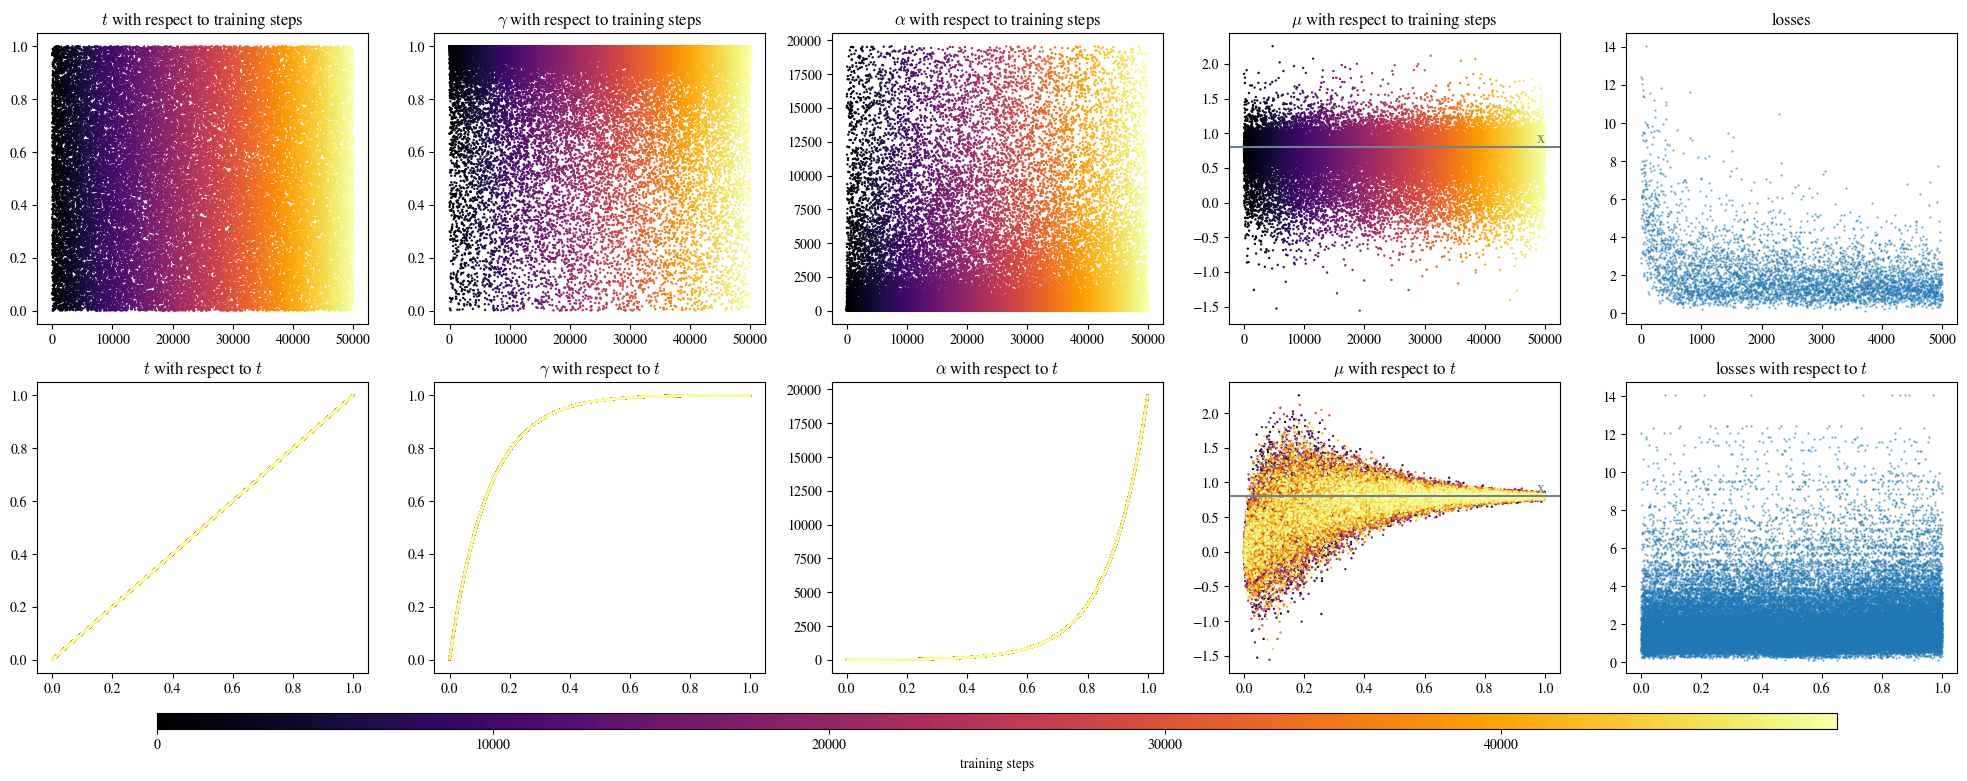

In [16]:
visualize_training(losses, ts, gammas, mus, alphas, x.item())

At each step of training we sample a batch of time points $t \in [0, 1]$, which, along with $\sigma_1$, allows us to automatically calculate $\gamma(t)$ which is used for computing $\hat{x}$ and $\alpha(t)$ which is used as a weight coefficient the loss (_Equation 41_). Note the $\alpha$ used here assumes continuous time $t$:
\begin{align}
\alpha(t) = -\frac{2 \ln \sigma_1}{\sigma_1^{2t}}. \tag{74}
\end{align}

Top row, from left to right:
- The sampled time points $t$ ranging from 0 to 1 plotted against the training steps ranging from 0 to 50k.
- The $\gamma(t)$ derived from the sampled time points plotted against the training steps ranging from 0 to 50k.
- The $\alpha(t)$ derived from the sampled time points plotted against the training steps ranging from 0 to 50k.
- The $\mu(t)$ sampled from the Bayesian flow distribution at the sampled time points plotted against the training steps ranging from 0 to 50k.
- The raw training loss plotted against the training steps ranging from 0 to 50k.

Bottom row, from left to right:
- The sampled time points $t$ ranging from 0 to 1 plotted against themselves.
- The $\gamma(t)$ derived from the sampled time points plotted against the sampled time points they were derived from.
- The $\alpha(t)$ derived from the sampled time points plotted against the sampled time points they were derived from.
- The $\mu(t)$ sampled from the Bayesian flow distribution at the sampled time points plotted against the same sampled time points.
- The raw training loss plotted against the sampled time points they were evaluated at. 

Note:
- The distribution of $\mu$ start arond $\mu_0=0$, expand outwards, and then concentrate around the ground truth $x = 0.8$ as $t$ goes from $0$ to $1$.
- The distribution of loss values remains constant across different time points $t$.

# Generation
Having trained the network to estimate $\hat{x}$ from $\mu$ and $t$, we can recursively generate a sequence of $\mu_1, ..., \mu_n$ from initial parameters $\mu_0=0$, $\rho_0=1$ by computing $\hat{x}_i$ from $\mu_{i-1}, t_{i-1}$ with the network, sampling $y$ from a sender distribution centered around $\hat{x}_i$ (which is equivalent to the receiver distribution conditioned on $\mu_{i-1}$ and $t_{i-1}$), and using the Bayesian update function to produce $\mu_i$ given $\mu_{i-1}$ and $y$. Note the $\alpha$ used is not the $\alpha$ defined in _Equation 74_ because the generation process is over discrete time-steps. Rather $\alpha$ is calculated as the difference between consecutive $\beta$ as
\begin{align}
\alpha(i) &= \beta(t_i) - \beta(t_{i-1}) \tag{93} \\
&= \sigma_1^{-2i/n} - \sigma_1^{-2(i-1)/n} \tag{94} \\
&= \sigma_1^{-2i/n} \left(1-\sigma_1^{2/n}\right) \tag{95}.
\end{align}
The $\hat{x}$ are clipped both during training time and generation time, to be in [-1, 1]. The generation process subdivides the interval $[0,1]$ into 1000 steps.

In [17]:
samples, idxs, ts, gammas, alphas, ys, mus, rhos = generate(
    network, indim=1, num_iters=1000, num_samples=20, config=sampling_cfg)

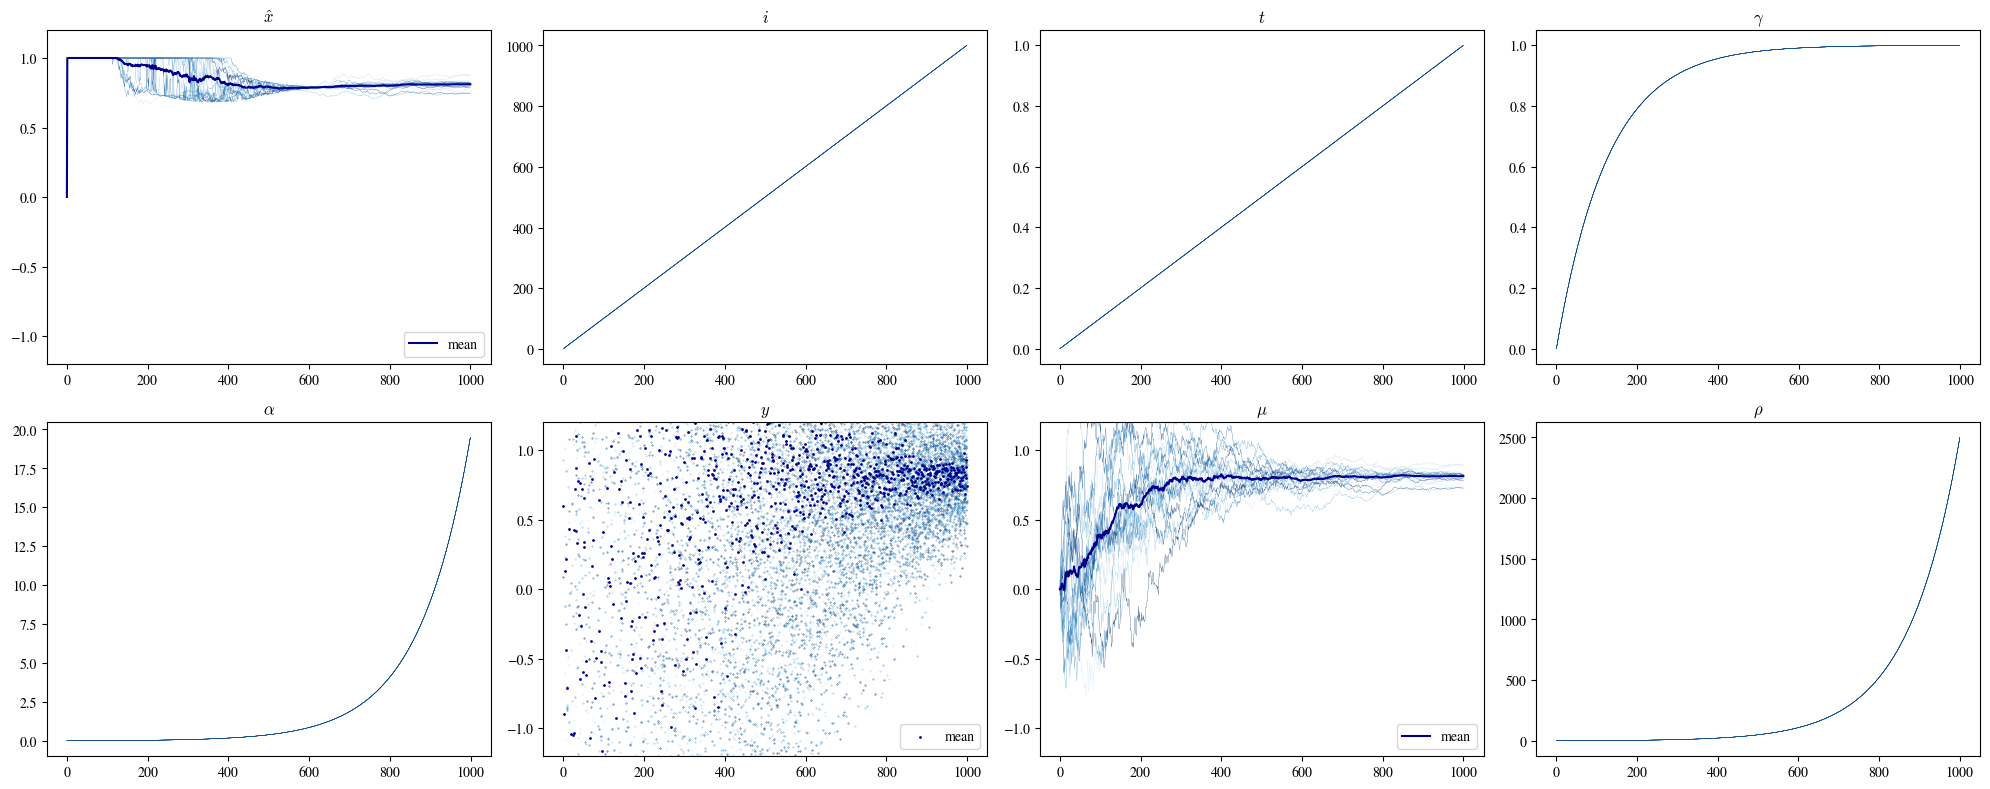

In [18]:
visualize_generation(samples, idxs, ts, gammas, alphas, ys, mus, rhos)

Top row, from left to right:
- The trajectory of $\hat{x}$ for multiple runs plotted against the number of sampling steps over the course of the generation process.
- The number of sampling steps plotted against itself.
- The continuously valued time point $t$ plotted against the number of sampling steps over the course of the generation process.
- The Bayesian flow distribution parameter, $\gamma$, plotted against the number of sampling steps over the course of the generation process.


Bottom row, from left to right:
- The accuracy rate $\alpha$ plotted against the number of sampling steps over the course of the generation process.
- The receiver samples $y$ for multiple runs plotted against the number of sampling steps over the course of the generation process.
- The trajectory of $\mu$ for multiple runs plotted against the number of sampling steps over the course of the generation process.
- The precision of the input distribution $\rho$ plotted against the number of sampling steps over the course of the generation process.

Note:
- The spread of samples $y$ is much larger than the spread of the parameter updates for $\mu$.
- The spread of the parameter updates for $\mu$ is larger than the spread of the data estimates $\hat{x}$.
- The $\hat{x}$ is clipped to be in [-1, 1].
- Both the precision of the receiver distribution $\alpha$ and the precision of the input distribution $\rho$ increase exponentially over the course of the generation process.
- The relationship $\sigma_1^2 = \rho(1)^{-1}$ should have us expect that the final value of $\rho$ should be 2500 given $\sigma_1=0.02$. This is indeed the case.